# Areal Project

<div>
<img src="logo.jpg" width=150 ALIGN="left" border="20">
<h1> Starting Kit for raw data (images)</h1>
<br>This code was tested with <br>
Python 3.6.7 <br>
Created by Areal Team <br><br>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div>
    <h2>Introduction </h2>
     <br>
Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.
<br>
In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
    Data comes from part of the data set (NWPU-RESISC45) originally used in <a href="https://arxiv.org/pdf/1703.00121.pdf?fbclid=IwAR16qo-EX_Z05ZpxvWG8F-oBU0SlnY-3BPCWBVVOGPyJcVy7BBqCKjnsvJo">Remote Sensing Image Scene Classification</a>. This data set contains 45 categories while we only kept 13 out of them.

References and credits: 
Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements 

The next cell will install all the required dependencies on your computer. You should consider replacing pip with pip3 if pip is related to python2.7 on your computer, or comment it if you already have the dependencies/are running in the docker of the challenge (runnable with the name areal/codalab:pytorch if you know how to run a docker).

In [1]:
#!pip install --user -r requirements.txt

In [2]:
import numpy as np
import random
import re

In [3]:
model_dir = "sample_code_submission"
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

In [4]:
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);

Go through the challenge website and watch the trailer video.

#### Question 1: Briefly explain the problem.

We are to classify images of certain landscapes to 13 different classes(beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland).

#### Question 2: What is the scoring metric used to evaluate submissions?

The accuracy that is used to evaluate submission is the percentage of rightly identified(prediction==solution) classes.

aacuracy = (n_true_positive + n_true_negative) / (n_all_samples)


<div>
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
</div>

In [5]:
# data_dir = 'sample_data'
data_dir = '/home/mykola/Downloads/public_dat' # download "public_data" from the challenge website
data_name = 'Areal'

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

In [6]:
from ingestion_program.data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)

Reading /home/mykola/Downloads/public_dat/Areal_train from AutoML format
Number of examples = 5200
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [7]:
data.shape

(5200, 49153)

In [8]:
data.head()

,pixel_1_1_R,pixel_1_1_G,pixel_1_1_B,pixel_1_2_R,pixel_1_2_G,pixel_1_2_B,pixel_1_3_R,pixel_1_3_G,pixel_1_3_B,pixel_1_4_R,...,pixel_128_126_R,pixel_128_126_G,pixel_128_126_B,pixel_128_127_R,pixel_128_127_G,pixel_128_127_B,pixel_128_128_R,pixel_128_128_G,pixel_128_128_B,target
0,109,134,112,64,89,67,90,114,90,109,...,92,115,89,100,120,95,107,127,102,island
1,68,73,66,63,68,61,66,69,62,72,...,83,79,67,112,105,95,115,108,100,beach
2,119,142,122,110,134,112,104,129,107,104,...,131,132,136,130,131,136,134,135,140,beach
3,203,187,171,196,180,164,195,180,161,192,...,132,114,100,105,87,73,57,39,25,chaparral
4,229,222,203,227,220,201,225,218,199,233,...,83,105,102,59,81,78,82,104,101,beach


In [9]:
# data.describe()

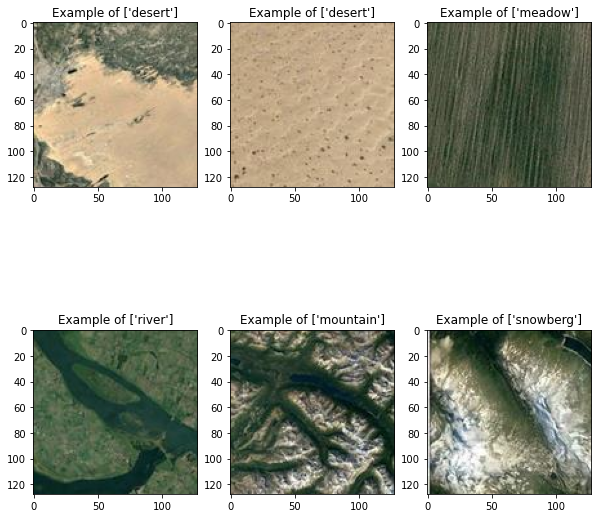

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

num_toshow = 6
fig, _axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for i in range(num_toshow):
    img = data.iloc[i].values[:-1].reshape(128,128,3)
    label = data.iloc[i].values[-1:]
    axs[i].set_title('Example of {}'.format(label))
    axs[i].imshow(img.astype(float) / 255)

plt.show()

In [11]:
print(data.iloc[:, -1:])
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

      target
0     desert
1     desert
2     meadow
3      river
4   mountain
..       ...
60    island
61    island
62      lake
63     beach
64    forest

[65 rows x 1 columns]


In [14]:
np.unique(data["target"]).shape

(13,)

In [15]:
data[data["target"]=="island"].shape

(5, 49153)

#### Code 1: compute statistics of the dataset.

* How many features?
* How many data points?
* How many classes?
* What is the most represented class?
* What is the least represented class?

In [35]:
#Features: 128*128*3
#Data points: 5200
#Classes: 13
#They are equally represented: all by 400 samples

# Step 2 : Building a predictive model

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
This time, also, still make sure that your RAM has at least 2-3GB available.

In [7]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=False, verbose=True)
print(D)

Info file found : /home/mykola/Downloads/public_dat/Areal_public.info
========= Reading /home/mykola/Downloads/public_dat/Areal_feat.type
[+] Success in  0.00 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_train.data
[+] Success in 78.92 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_train.solution
[+] Success in  0.01 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_valid.data
[+] Success in 29.10 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_valid.solution
[+] Success in  0.00 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_test.data
[+] Success in 29.74 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_test.solution
[+] Success in  0.00 sec
DataManager : Areal
info:
	usage = Sample dataset Areal data
	name = areal
	task = multiclass.classification
	target_type = Categorical
	feat_type = Numerical
	metric = accuracy
	time_budget = 12000
	feat_num = 49152
	target_num = 13
	label_num = 13
	train_num = 

In [8]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']
X_train.shape, Y_train.shape

((5200, 49152), (5200, 1))

In [10]:
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(D.data['X_valid'])
X_test = scaler.transform(D.data['X_test'])

In [11]:
from sklearn.model_selection import train_test_split
Xx_train, Xx_test, yy_train, yy_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
Xx_train.shape, Xx_test.shape, yy_train.shape, yy_test.shape

((4160, 49152), (1040, 49152), (4160, 1), (1040, 1))

### Processing

Basically, there are two approaches:

* Use raw data as input. This may be the good way to go with, for instance, deep learning models.
* Do feature engineering: process the data to create features. You can then use this features as the input of your classifier (Random forest, SVM, etc.). An example of feature is the number of blue pixel in the image. Feature extraction can also be done by a CNN.

In [9]:
# TODO (if you want)

### Use of the baseline model

Using our BasicCNN model needs PyTorch libraries installed.

In case you have them but still encounter errors related to them, you should probably do an upgrade : 

    pip install -U torch

Our model is a simple implementation of a Convolutional Neural Network (CNN).

More information on CNN:
* [Convolutional neural network on Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [A Comprehensive Guide to Convolutional Neural Networks (blog)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from torchvision import transforms
from sklearn.base import BaseEstimator
from sklearn.preprocessing import normalize
from PIL import Image
from os.path import isfile
import torchvision
import PIL
import imgaug.augmenters as iaa

from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)


seq = iaa.Sequential([
#     iaa.Crop(percent=(0, 0.1)),
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0, 3.0)),
#     iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)
#     ),
    iaa.LinearContrast((0.75, 1.5)),
])

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(10),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])

def requires_grad(p):
    return p.requires_grad


class SimpleConvModel(nn.Module):
    def __init__(self, out_channel_conv=16, linear_hidden_size=128, out_class=13):
        super(SimpleConvModel, self).__init__()

        self.out_channel_conv = out_channel_conv
        self.linear_hidden_size = linear_hidden_size
        self.out_class = out_class

        self.seq1 = nn.Sequential(
                                  nn.Conv2d(3, self.out_channel_conv, (3,3), stride=3),
                                  nn.MaxPool2d(5),
                                  nn.ReLU(),
#                                   nn.Conv2d(self.out_channel_conv, self.out_channel_conv, (3,3), stride=1),
#                                   nn.MaxPool2d(2),
#                                   nn.ReLU()
                                 )

        self.seq2 = nn.Sequential(nn.Linear(self.out_channel_conv * 8 * 8, self.linear_hidden_size),#self.linear_hidden_size),
                                  nn.Dropout(0.25),
                                  nn.ReLU(),
                                  nn.Linear(self.linear_hidden_size, self.out_class),
                                  nn.Softmax(dim = 1))

    def forward(self, x):
        out1 = self.seq1(x)
#         print(out1.shape)
        out2 = out1.view(-1, self.out_channel_conv*8*8)
        out3 = self.seq2(out2)

        return out3

class BasicCNN(BaseEstimator):
    def __init__(self, learning_rate=1e-3, nb_epoch = 10, batch_size = 32, verbose=False, use_cuda=False,
                out_channel_conv=16, linear_hidden_size=128):
        super(BasicCNN, self).__init__()
        if learning_rate is None:
            learning_rate = 1e-3
        if nb_epoch is None:
            nb_epoch = 10
        if batch_size is None:
            batch_size = 32
        if verbose is None:
            verbose = False
        if use_cuda is None:
            use_cuda = False
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.use_cuda = use_cuda
#         self.model_conv = SimpleConvModel(out_channel_conv, linear_hidden_size)
        self.model_conv = torchvision.models.resnet.resnet34(num_classes=13)
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        if self.use_cuda:
            self.model_conv.cuda()
            self.criterion.cuda()
        # Optimizer
        print(learning_rate)
        self.optim = optim.Adam(self.model_conv.parameters(), lr=learning_rate, weight_decay=0.00005)

    def fit(self, X, Y):
        '''
            param X: numpy.ndarray
                shape = (num_sample, C * W * H)
                with C = 3, W = H = 128
            param Y: numpy.ndarray
                shape = (num_sample, 1)
        '''
        x_test = self.process_data(Xx_test, augment=False)
        y_test = self.process_label(yy_test)
        X = self.process_data(X)
        Y = self.process_label(Y)
        self.model_conv.train()
        nb_batch = int(X.shape[0] / self.batch_size)
        for e in range(self.nb_epoch):
            sum_loss = 0
            for i in range(nb_batch):
                self.optim.zero_grad()
                beg = i * self.batch_size
                end = min(X.shape[0], (i + 1) * self.batch_size)
                x = X[beg:end]
                y = Y[beg:end]
                if self.use_cuda:
                    x, y = x.cuda(), y.cuda()
                out = self.model_conv(x)
                loss = self.criterion(out, y)
                loss.backward()
                self.optim.step()
                sum_loss += loss.item()
#                 print(loss.item())
            sum_loss /= nb_batch
            if self.verbose:
                print("Epoch %d : loss = %f" % (e, sum_loss))
                pred_score = scoring_function(yy_train, self.predict(X, preproc=False))
                print('Training score for the', metric_name, 'metric = %5.4f' % pred_score)
                print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(yy_test, self.predict(x_test, preproc=False)))
                
        return pred_score

    def process_data(self, X, augment=True):
        print('fst sample', X[0][0])
        n_sample = X.shape[0]
        X = X.reshape(n_sample, 3, 128, 128)
        mean = np.mean(X, axis=1)[:, np.newaxis]
        std = np.std(X, axis=1)[:, np.newaxis]


#         if augment or True:
#             ls = []
#             for sample in X:
#                 ls.append(transforms_pytorch(sample.reshape(128,128,3)))
#             X = torch.stack(ls)
# # #             X = X + 0.1*np.random.uniform(size=X.shape)
# # #             X = seq(images=X)

# #         X = (X - 127.5) / 127.5
#             X = X.cpu().numpy()


        
        
#         X = (X - mean) / (std + 1e-8)

        X = X.astype(np.float)# / 255.

        print(X.max(), X.min())
        return torch.Tensor(X)

    def process_label(self, y):
        res = torch.zeros(1)
        for i in range(y.shape[0]):
            l = torch.Tensor([y[i,0]])
            res = torch.cat((res, l))
        return res[1:].type(torch.long)

    def predict_all(self, X):
        self.model_conv.eval()
        X = self.process_data(X)
        if self.use_cuda:
            X = X.cuda()
        pred = self.model_conv(X).argmax(dim=1).cpu().numpy()
        return pred
    
    def predict(self, X, preproc=True):
        '''
            param X: numpy.ndarray
                shape = (num_sample, C * W * H)
                with C = 3, W = H = 128
            return: numpy.ndarray
                of int with shape (num_sample) ?
                of float with shape (num_sample, num_class) ?
                of string with shape (num_sample) ?
        '''
        # inverted_dico = {v:k for k,v in self.label_dico.items()}
        self.model_conv.eval()
        
        if preproc:
            X = self.process_data(X, augment=False)

        nb_batch = int(X.shape[0] / self.batch_size)
        pred = []
        for i in range(nb_batch):
            beg = i * self.batch_size
            end = min(X.shape[0], (i + 1) * self.batch_size)
            x = X[beg:end]
            
            if self.use_cuda:
                x = x.cuda()
            preds = self.model_conv(x).argmax(dim=1).cpu().numpy()
            pred.append(preds)
        
        if end !=X.shape[0]:
            x = X[end:]

            if self.use_cuda:
                x = x.cuda()
            preds = self.model_conv(x).argmax(dim=1).cpu().numpy()
            pred.append(preds)
        pred = np.array([[item] for sublist in pred for item in sublist])

        return pred

    def save(self, path="./"):
        pickle.dump(self, open(path + '_model.pickle', "wb"))

    def load(self, path="./"):
        modelfile = path + '_model.pickle'
        if isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        return self

Using scoring metric: accuracy


In [33]:
import gc

del m
gc.collect()

import torch
torch.cuda.empty_cache()

In [34]:
m = BasicCNN(verbose=True, use_cuda=True, nb_epoch=20, batch_size=16, learning_rate=0.0001,
            out_channel_conv=64, linear_hidden_size=64)
# print(m.model_conv)
trained_model_name = model_dir + '/' + data_name

0.0001


In [ ]:
m.nb_epoch = 250
res = m.fit(Xx_train, yy_train)

fst sample 0.43137254901960786
1.0 0.0
fst sample 0.27058823529411763
1.0 0.0


In [67]:
# # torch.autograd.set_detect_anomaly(True)
# out_channel_convs = [512, ]
# linear_hidden_size = [64,256,512]
# lrs = [0.001, 0.0001]
# ress = {}
# for chn in out_channel_convs:
#     for hidden in linear_hidden_size:
#         for lr in lrs:

#             gc.collect()
#             torch.cuda.empty_cache()

#             m = BasicCNN(verbose=True, use_cuda=True, nb_epoch=10, batch_size=8, learning_rate=lr,
#                     out_channel_conv=chn, linear_hidden_size=hidden)
#             trained_model_name = model_dir + '/' + data_name
#             res = m.fit(X_train.reshape((-1,128,128,3)), Y_train)
#             ress[(chn, hidden, lr)] = res
#             del m

In [24]:
import gc

gc.collect()

import torch
torch.cuda.empty_cache()

In [17]:
m.save(trained_model_name)  
m.batch_size = 4
Y_hat_train = m.predict(X_train)
Y_hat_valid = m.predict(X_valid)
Y_hat_test = m.predict(X_test)
m.batch_size = 8

fst sample 0.42745098039215684
1.0 0.0
fst sample 0.054901960784313725
1.0 -0.032388663967611336
fst sample 0.23529411764705882
1.0 -0.032388663967611336


In [18]:
m.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


#### Question 3: What are the hyperparameters of a CNN?

Apart from learning parameters such as number of layers similar to a normal neural net the CNN specifically has the size of the kernels that are used to detect features, the step size with which the kernel is applied as well as padding of the sides of the image.

#### Code 2: Edit model.py to vary the CNN's hyperparameter

In [21]:
#TODO in model.py

#### Code 3: Try another model (e.g. Random Forest, SVM, etc.)

In [22]:
#TODO in another model.py file

# Scoring the result

Obviously, since it is made with sample_data, which has too few samples, results won't be really good

In [19]:
from libscores import get_metric
import libscores
type(libscores)

module

In [20]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [21]:
len(D.data['Y_valid']), len(D.data['Y_test'])

(0, 0)

In [22]:
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
if len(D.data['Y_valid']) > 0 and len(D.data['Y_test']) > 0:
    print('Valid score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_valid'], Y_hat_valid))
    print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_test'], Y_hat_test))

Ideal score for the accuracy metric = 1.0000
Training score for the accuracy metric = 0.6687


## Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
conf_matr = confusion_matrix(Y_train[:Y_hat_train.shape[0]], Y_hat_train)
conf_matr

array([[  0,  16,  54,  22,   0,  65,   2,   0,  50,  78,  44,  65,   4],
       [  0, 274,   1,  11,  62,   0,   0,   0,  24,   6,   0,   1,  21],
       [  0,   2, 229,   6,   3,  28,   5,   0,  12,  46,  35,  18,  16],
       [  0,  10,   1, 352,   0,   0,   0,   0,  25,   3,   0,   8,   1],
       [  0,   0,   0,   0, 360,   0,   0,   4,   0,   9,   0,   0,  27],
       [  0,   0,  14,   3,   4, 322,   5,   0,   6,  35,   9,   0,   2],
       [  0,  38,   6,   1,  18,  10, 193,   9,  24,  68,   3,   7,  23],
       [  0,   0,   0,   1,  12,   0,   2, 362,   5,   5,   0,   0,  13],
       [  0,  31,   3,  19,  39,   2,   8,  20, 176,  63,   2,   8,  29],
       [  0,  18,   8,   3,  21,   1,  18,  14,  19, 267,   8,   4,  19],
       [  0,   0,  15,   0,   1,  16,   1,   0,   0,  20, 342,   5,   0],
       [  0,   7,   5,   0,   1,   0,   0,   0,   4,   4,   0, 379,   0],
       [  0,   0,   1,   0,  70,   3,  17,  30,  26,  27,   4,   1, 221]])

<AxesSubplot:>

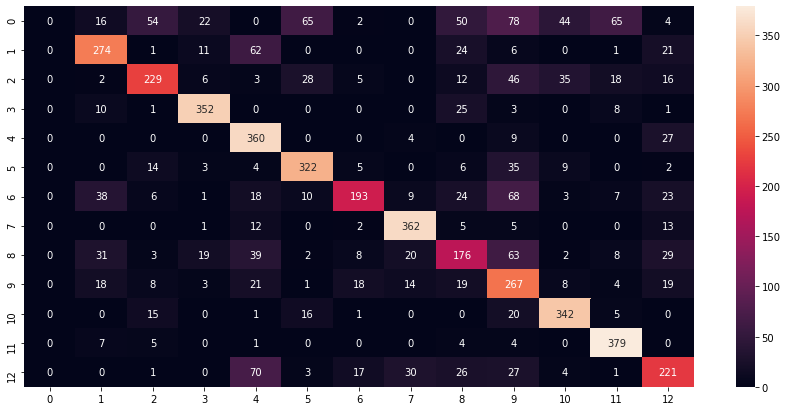

In [31]:
plt.figure(figsize = (15,7))
sn.heatmap(conf_matr, annot=True,  fmt='g')

#### Question 4: what does the confusion matrix represent?

On one axis the confusion matrix shows the predictions and on one side the solutions. The middle diagonal shows where both are the same. To the side there are cases where may a beach is classified as mountains. If there is a large number of missclassification between two classes that means that the model has difficulties distinguishing the two(so one could create features to differentiate the two, or change the model architecture)

#### Code 4: display the confusion matrix with a colored heatmap

In [101]:
# TODO

## Cross validation

CV scores on sample_data doesn't have enough data, and so isn't meaningful.
Run it with the full data to see meaningful values.

In [29]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [36]:
scores = cross_val_score(BasicCNN(), X_train, Y_train, cv=3, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

/home/mykola/anaconda3/envs/cuda9/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KeyboardInterrupt: 

#### Question 5: Why is there a standard deviation associated with the cross-validation score?

The cross validation uses several folds(or particitions) of the data. Each of these folds hasits accuracy score, in the end the scores of all folds are added. The variations thus shows the variation of the scores. A low variation shows that the model did similarily well on all folds it is therefore more consistent and might be preferable to a different model with similar score and higher variability because it is more consistent.

# Submission

## Example

Example needs to have python3 installed

Test to see whether submission with ingestion program is working

In [102]:
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /home/mykola/Downloads/public_dat
Using output_dir: /home/mykola/Projects/TP5/sample_result_submission
Using program_dir: /home/mykola/Projects/TP5/ingestion_program
Using submission_dir: /home/mykola/Projects/TP5/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Areal ********
************************************************
========= Reading and converting data ==========
Info file found : /home/mykola/Downloads/public_dat/Areal_public.info
========= Reading /home/mykola/Downloads/public_dat/Areal_feat.type
[+] Success in  0.00 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_train.data
[+] Success in 76.66 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_train.solution
[+] Success in  0.02 sec
========= Reading /home/mykola/Downloads/public_dat/Areal_valid.data
[+] Success in 28.21 sec
========= Reading /home/mykola/Downloads/public_dat/Are

### Test scoring program

In [50]:
scoring_output_dir = 'scoring_output'
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Areal_train): accuracy(set1_score)=0.783461538462 =======


# Prepare the submission

In [59]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./sample_code_submission_20-12-30-12-31.zip
./sample_result_submission_20-12-30-12-31.zip


# Try to submit your submissions on Codalab!